In [9]:
import dicom
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
import tensorflow as tf
import numpy as np
from tqdm import tqdm_notebook
import scipy.misc
from skimage import io
import scipy.stats
import seaborn as sns
import skimage.color
from skimage.filters import threshold_otsu
import keras

from matplotlib import animation
from IPython.display import HTML
from PIL import Image
import pandas as pd
import nibabel as nib
from nibabel.testing import data_path
import dill

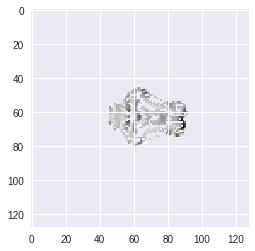

In [10]:
realigned_atlas = nib.load('../Data/big_atlas/coregistered_pig_2_atlas.nii').get_data()
#original_atlas = nib.load('../../Data/big_atlas/atlas.nii').get_data()
anatomical = nib.load('../Data/pig_2/coregistered_anatomy.nii').get_data()
mean_fmri = nib.load('../Data/pig_2/rfmri nii/meanus822-0016-00001-000001-01.nii').get_data()  

mask_roi_1 = np.ma.masked_where(np.isin(realigned_atlas, [0]), realigned_atlas)
fmri_masked_roi = np.ma.masked_where(np.ma.getmask(mask_roi_1), mean_fmri) 
# print(fmri_masked_roi)
plt.imshow(fmri_masked_roi[:,:,10])

In [11]:
# let's try loading the entire thing to ram
# the big tensor will have dimension [time, height, width, depth]

im = mean_fmri
all_data = np.zeros((300, im.shape[0], im.shape[1], im.shape[2]))
masked_data = np.ma.zeros((300, im.shape[0], im.shape[1], im.shape[2]))

dicom_files = [x for x in Path('../Data/pig_2/rfmri nii/').iterdir() if x.is_file() and not 'ds_store' in str(x).lower()]
dicom_files.sort(key=str)
time_index = 0
mask_roi_1 = np.ma.masked_where(np.isin(realigned_atlas, [0]), realigned_atlas)

for f in tqdm_notebook(dicom_files):
    time_file = nib.load(str(f)).get_data()
    fmri_masked_roi = np.ma.masked_where(np.ma.getmask(mask_roi_1), time_file) 
    try:
        masked_data[time_index, ...] = fmri_masked_roi
        all_data[time_index, ...] = time_file
        time_index += 1
    except:
        print(f)

../Data/pig_2/rfmri nii/meanus822-0016-00001-000001-01.nii



In [12]:
assert all_data.shape == (300, 128, 128, 20) #300 time samples, 128x128 image, over 20 slices in z-index
assert masked_data.shape == (300, 128, 128, 20) # basic sanity check

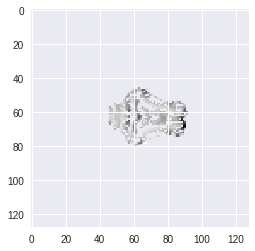

In [13]:
plt.imshow(masked_data[1,:,:,10]) # Mask is generated from an atlas, atlas disregards certain subcortical regions that are just "grey matter"

In [14]:
indices = masked_data[1,:,:,:].nonzero()
df_index = pd.MultiIndex.from_tuples(list(zip(*indices)), names=['row', 'col', 'depth'])
series_df = pd.Series(index=df_index, dtype=object)

for i, triple in tqdm_notebook(enumerate(zip(*indices)), total=len(indices[0])):
    x, y, z = triple
    trace = all_data[:, x, y, z]
    
    series_df.loc[triple] = trace

data_block = np.vstack(series_df.values)[..., np.newaxis]



In [15]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import quniform, uniform
from keras.callbacks import LearningRateScheduler

import math

def data():
    realigned_atlas = nib.load('../Data/big_atlas/coregistered_pig_2_atlas.nii').get_data()
    mean_fmri = nib.load('../Data/pig_2/rfmri nii/meanus822-0016-00001-000001-01.nii').get_data()  

    mask_roi_1 = np.ma.masked_where(np.isin(realigned_atlas, [0]), realigned_atlas)
    fmri_masked_roi = np.ma.masked_where(np.ma.getmask(mask_roi_1), mean_fmri)
    
    im = mean_fmri
    all_data = np.zeros((300, im.shape[0], im.shape[1], im.shape[2]))
    masked_data = np.ma.zeros((300, im.shape[0], im.shape[1], im.shape[2]))

    dicom_files = [x for x in Path('../Data/pig_2/rfmri nii/').iterdir() if x.is_file() and not 'ds_store' in str(x).lower()]
    dicom_files.sort(key=str)
    time_index = 0
    mask_roi_1 = np.ma.masked_where(np.isin(realigned_atlas, [0]), realigned_atlas)

    for f in dicom_files:
        time_file = nib.load(str(f)).get_data()
        fmri_masked_roi = np.ma.masked_where(np.ma.getmask(mask_roi_1), time_file) 
        try:
            masked_data[time_index, ...] = fmri_masked_roi
            all_data[time_index, ...] = time_file
            time_index += 1
        except:
            print(f)
    
    
    indices = masked_data[1,:,:,:].nonzero()
    df_index = pd.MultiIndex.from_tuples(list(zip(*indices)), names=['row', 'col', 'depth'])
    series_df = pd.Series(index=df_index, dtype=object)

    for i, triple in enumerate(zip(*indices)):
        x, y, z = triple
        trace = all_data[:, x, y, z]

        series_df.loc[triple] = trace
    data_block = np.vstack(series_df.values)[..., np.newaxis]
    
    shuffled_data = np.copy(data_block)
    np.random.shuffle(shuffled_data)

    testing_set = shuffled_data[:700]  #hold back 700 for validation
    training_set = shuffled_data[700:]
    
    train_mean = training_set.mean(axis=0)
    train_std = training_set.std(axis=0)
    
    x_train = y_train = (training_set - train_mean) / train_std
    x_test = y_test = (testing_set - train_mean) / train_std
    
    return x_train, y_train, x_test, y_test
    
    

def model(x_train, y_train, x_test, y_test):
    from keras.layers.convolutional import Conv1D, UpSampling1D
    from keras.layers.pooling import MaxPooling1D
    from keras.layers.core import Dense, Activation
    from keras.layers.normalization import BatchNormalization
    
    model = keras.models.Sequential()
    
    c1_size = int({{quniform(50, 70, 1)}})
    c1_length = int({{quniform(3, 10, 2)}})
    
    c2_size = int({{quniform(20, 40, 1)}})
    c2_length = int({{quniform(3, 10, 2)}})
    
    c3_size = int({{quniform(10, 30, 1)}})
    c3_length = int({{quniform(3, 10, 2)}})
    
    c4_size = int({{quniform(3, 8, 1)}})
    c4_length = int({{quniform(3, 10, 2)}})
      
    # encoder
    model.add(Conv1D(c1_size, c1_length, 
                     padding='causal', input_shape=[300, 1])) #Dimensionality 300
    model.add(BatchNormalization(momentum={{uniform(0, 1)}}))
    model.add(Activation('relu'))

    model.add(Conv1D(c2_size, c2_length, 
                     padding='causal'))
    model.add(BatchNormalization(momentum={{uniform(0, 1)}}))
    model.add(Activation('relu'))
    model.add(MaxPooling1D())
    
    model.add(Conv1D(c3_size, c3_length, 
                     padding='causal')) # Activation map size [150 x 1]
    model.add(BatchNormalization(momentum={{uniform(0, 1)}}))
    model.add(Activation('relu'))
    model.add(MaxPooling1D())
    
    model.add(Conv1D(c4_size, c4_length, 
                     padding='causal')) # Activation map size [75 x 1]
    model.add(BatchNormalization(momentum={{uniform(0, 1)}}))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3))
    
    # Activation map size [25 x 1] 
    # Encoding represenation size is [25 x 1 x N (8)] = 200
    # Dimensionality reduction of 300 -> 200
    
    # decoder
    model.add(Conv1D(c4_size, c4_length, 
                     padding='causal'))
    model.add(BatchNormalization(momentum={{uniform(0, 1)}}))
    model.add(Activation('relu'))
    model.add(UpSampling1D(size=3))
    
    model.add(Conv1D(c3_size, c3_length, 
                     padding='causal'))
    model.add(BatchNormalization(momentum={{uniform(0, 1)}}))
    model.add(Activation('relu'))
    model.add(UpSampling1D())
    
    model.add(Conv1D(c2_size, c2_length, 
                     padding='causal'))
    model.add(BatchNormalization(momentum={{uniform(0, 1)}}))
    model.add(Activation('relu'))
    model.add(UpSampling1D())
    
    model.add(Conv1D(c1_size, c1_length, 
                     padding='causal'))
    model.add(BatchNormalization(momentum={{uniform(0, 1)}}))
    model.add(Activation('relu'))
    
    model.add(Conv1D(1, 1, padding='causal'))
    model.add(Activation('linear'))
    
    # section 2.1 mentions a special regularization, but I don't think that is going to work
    # the feature map in the compressed representation and the output will not be timeshuffled if we use causal conv
    
    # learning rate schedule
    def step_decay(epoch):
        initial_lrate = 0.01
        drop = 0.5
        epochs_drop = {{quniform(4, 10, 1)}}
        lrate = initial_lrate * drop**(np.floor((1+epoch)/epochs_drop))
        return lrate
    lrate = LearningRateScheduler(step_decay)
    
    kicker = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=10, 
                                               verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
    
    callbacks_list = [keras.callbacks.TerminateOnNaN(), kicker]
    
    model.compile(optimizer={{choice(['sgd', 'adam', 'rmsprop', 'nadam'])}}, loss='logcosh')
    model.fit(x_train, y_train, epochs=10, batch_size={{choice([32, 64, 128, 256])}}, 
              callbacks=callbacks_list, validation_data=(x_test, x_test), verbose=2)
    
    loss = model.evaluate(x_test, x_test)
    
    if np.isnan(loss):
        loss = float('inf')
        
    
    return {'loss': loss, 'status': STATUS_OK, 'model': model}

    

In [16]:
from hyperopt.mongoexp import MongoTrials

# getting this thing to work with mongotrials is NonTrivial, but also NonImpossible
# trials = MongoTrials('mongo://localhost:1234/foo_db/jobs', exp_key='exp1')

best_run, best_model = optim.minimize(model=model, data=data, algo=tpe.suggest, 
                                      max_evals=200, trials=Trials(),
                                     notebook_name='Experiment 11 - hyperopt', verbose=True)
    

>>> Imports:
#coding=utf-8

try:
    import dicom
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    from pathlib import Path
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    from tqdm import tqdm_notebook
except:
    pass

try:
    import scipy.misc
except:
    pass

try:
    from skimage import io
except:
    pass

try:
    import scipy.stats
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    import skimage.color
except:
    pass

try:
    from skimage.filters import threshold_otsu
except:
    pass

try:
    import keras
except:
    pass

try:
    from matplotlib import animation
except:
    pass

try:
    from IPython.display import HTML
except:
    pass

try:
    from PIL import Image
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import nibabel as nib
except:
    pass

try:
    from nibabel.testing import data_path
except

../Data/pig_2/rfmri nii/meanus822-0016-00001-000001-01.nii
Train on 6455 samples, validate on 700 samples
Epoch 1/10
3s - loss: 0.0910 - val_loss: 0.0554
Epoch 2/10
1s - loss: 0.0389 - val_loss: 0.0366
Epoch 3/10
1s - loss: 0.0334 - val_loss: 0.0345
Epoch 4/10
1s - loss: 0.0313 - val_loss: 0.0156
Epoch 5/10
1s - loss: 0.0260 - val_loss: 0.0590
Epoch 6/10
1s - loss: 0.0260 - val_loss: 0.0099
Epoch 7/10
1s - loss: 0.0248 - val_loss: 0.0167
Epoch 8/10
1s - loss: 0.0251 - val_loss: 0.0076
Epoch 9/10
1s - loss: 0.0229 - val_loss: 0.0096
Epoch 10/10
1s - loss: 0.0256 - val_loss: 0.0077
384/700 [===============>..............] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/10
2s - loss: 0.1144 - val_loss: 0.0366
Epoch 2/10
0s - loss: 0.0312 - val_loss: 0.0472
Epoch 3/10
0s - loss: 0.0238 - val_loss: 0.0163
Epoch 4/10
0s - loss: 0.0201 - val_loss: 0.0153
Epoch 5/10
0s - loss: 0.0182 - val_loss: 0.0101
Epoch 6/10
0s - loss: 0.0214 - val_loss: 0.0112
Epoch 7/10
0s - loss: 0.0172

4s - loss: 0.0874 - val_loss: 0.0255
Epoch 2/10
0s - loss: 0.0246 - val_loss: 0.0328
Epoch 3/10
0s - loss: 0.0167 - val_loss: 0.0118
Epoch 4/10
0s - loss: 0.0153 - val_loss: 0.0213
Epoch 5/10
0s - loss: 0.0179 - val_loss: 0.0305
Epoch 6/10
0s - loss: 0.0153 - val_loss: 0.0106
Epoch 7/10
0s - loss: 0.0132 - val_loss: 0.0189
Epoch 8/10
0s - loss: 0.0116 - val_loss: 0.0155
Epoch 9/10
0s - loss: 0.0113 - val_loss: 0.0104
Epoch 10/10
0s - loss: 0.0122 - val_loss: 0.0155
700/700 [==============================] - 0s     
Train on 6455 samples, validate on 700 samples
Epoch 1/10
6s - loss: 0.0566 - val_loss: 0.0366
Epoch 2/10
3s - loss: 0.0397 - val_loss: 0.0157
Epoch 3/10
3s - loss: 0.0375 - val_loss: 0.1113
Epoch 4/10
3s - loss: 0.0335 - val_loss: 0.0086
Epoch 5/10
3s - loss: 0.0339 - val_loss: 0.0932
Epoch 6/10
3s - loss: 0.0323 - val_loss: 0.0332
Epoch 7/10
3s - loss: 0.0347 - val_loss: 0.0178
Epoch 8/10
3s - loss: 0.0313 - val_loss: 0.0169
Epoch 9/10
3s - loss: 0.0303 - val_loss: 0.0321


1s - loss: 0.0276 - val_loss: 0.0157
Epoch 4/10
1s - loss: 0.0237 - val_loss: 0.0210
Epoch 5/10
1s - loss: 0.0228 - val_loss: 0.0430
Epoch 6/10
1s - loss: 0.0180 - val_loss: 0.0276
Epoch 7/10
1s - loss: 0.0189 - val_loss: 0.0204
Epoch 8/10
1s - loss: 0.0167 - val_loss: 0.0093
Epoch 9/10
1s - loss: 0.0165 - val_loss: 0.0069
Epoch 10/10
1s - loss: 0.0158 - val_loss: 0.0134
700/700 [==============================] - 0s     
Train on 6455 samples, validate on 700 samples
Epoch 1/10
6s - loss: 0.0673 - val_loss: 0.2360
Epoch 2/10
1s - loss: 0.0237 - val_loss: 0.2115
Epoch 3/10
1s - loss: 0.0201 - val_loss: 0.1880
Epoch 4/10
1s - loss: 0.0205 - val_loss: 0.1565
Epoch 5/10
1s - loss: 0.0173 - val_loss: 0.1184
Epoch 6/10
1s - loss: 0.0186 - val_loss: 0.0944
Epoch 7/10
1s - loss: 0.0147 - val_loss: 0.0709
Epoch 8/10
1s - loss: 0.0174 - val_loss: 0.0418
Epoch 9/10
1s - loss: 0.0162 - val_loss: 0.0375
Epoch 10/10
1s - loss: 0.0169 - val_loss: 0.0434
700/700 [==============================] - 0s  

0s - loss: 0.0162 - val_loss: 0.0134
Epoch 6/10
0s - loss: 0.0137 - val_loss: 0.0086
Epoch 7/10
0s - loss: 0.0147 - val_loss: 0.0395
Epoch 8/10
0s - loss: 0.0127 - val_loss: 0.0086
Epoch 9/10
0s - loss: 0.0120 - val_loss: 0.0152
Epoch 10/10
0s - loss: 0.0124 - val_loss: 0.0257
700/700 [==============================] - 0s     
Train on 6455 samples, validate on 700 samples
Epoch 1/10
9s - loss: 0.0583 - val_loss: 0.0160
Epoch 2/10
3s - loss: 0.0383 - val_loss: 0.0182
Epoch 3/10
3s - loss: 0.0348 - val_loss: 0.0113
Epoch 4/10
3s - loss: 0.0394 - val_loss: 0.0144
Epoch 5/10
3s - loss: 0.0345 - val_loss: 0.0306
Epoch 6/10
3s - loss: 0.0316 - val_loss: 0.0102
Epoch 7/10
3s - loss: 0.0301 - val_loss: 0.0145
Epoch 8/10
3s - loss: 0.0266 - val_loss: 0.0142
Epoch 9/10
3s - loss: 0.0257 - val_loss: 0.0162
Epoch 10/10
3s - loss: 0.0270 - val_loss: 0.0068
640/700 [==========================>...] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/10
8s - loss: 0.0891 - val_loss: 0.329

1s - loss: 0.0175 - val_loss: 0.0068
Epoch 8/10
1s - loss: 0.0153 - val_loss: 0.0105
Epoch 9/10
1s - loss: 0.0162 - val_loss: 0.0149
Epoch 10/10
1s - loss: 0.0144 - val_loss: 0.0065
700/700 [==============================] - 0s     
Train on 6455 samples, validate on 700 samples
Epoch 1/10
9s - loss: 0.1059 - val_loss: 0.0446
Epoch 2/10
1s - loss: 0.0325 - val_loss: 0.0272
Epoch 3/10
1s - loss: 0.0264 - val_loss: 0.0196
Epoch 4/10
1s - loss: 0.0243 - val_loss: 0.0233
Epoch 5/10
1s - loss: 0.0181 - val_loss: 0.0137
Epoch 6/10
1s - loss: 0.0189 - val_loss: 0.0116
Epoch 7/10
1s - loss: 0.0184 - val_loss: 0.0211
Epoch 8/10
1s - loss: 0.0171 - val_loss: 0.0100
Epoch 9/10
1s - loss: 0.0162 - val_loss: 0.0215
Epoch 10/10
1s - loss: 0.0146 - val_loss: 0.0094
700/700 [==============================] - 0s     
Train on 6455 samples, validate on 700 samples
Epoch 1/10
9s - loss: 0.1112 - val_loss: 0.0777
Epoch 2/10
1s - loss: 0.0479 - val_loss: 0.0323
Epoch 3/10
1s - loss: 0.0352 - val_loss: 0.04

1s - loss: 0.0157 - val_loss: 0.0085
Epoch 10/10
1s - loss: 0.0171 - val_loss: 0.0180
700/700 [==============================] - 0s     
Train on 6455 samples, validate on 700 samples
Epoch 1/10
11s - loss: 0.0656 - val_loss: 0.0525
Epoch 2/10
1s - loss: 0.0252 - val_loss: 0.0283
Epoch 3/10
1s - loss: 0.0214 - val_loss: 0.0111
Epoch 4/10
1s - loss: 0.0199 - val_loss: 0.0663
Epoch 5/10
1s - loss: 0.0202 - val_loss: 0.0970
Epoch 6/10
1s - loss: 0.0199 - val_loss: 0.0245
Epoch 7/10
1s - loss: 0.0176 - val_loss: 0.0265
Epoch 8/10
1s - loss: 0.0147 - val_loss: 0.0177
Epoch 9/10
1s - loss: 0.0169 - val_loss: 0.0554
Epoch 10/10
1s - loss: 0.0148 - val_loss: 0.0461
700/700 [==============================] - 0s     
Train on 6455 samples, validate on 700 samples
Epoch 1/10
10s - loss: 0.0954 - val_loss: 0.0234
Epoch 2/10
1s - loss: 0.0317 - val_loss: 0.0135
Epoch 3/10
1s - loss: 0.0266 - val_loss: 0.0360
Epoch 4/10
1s - loss: 0.0208 - val_loss: 0.0215
Epoch 5/10
1s - loss: 0.0203 - val_loss: 0.

700/700 [==============================] - 0s     
Train on 6455 samples, validate on 700 samples
Epoch 1/10
13s - loss: 0.0618 - val_loss: 0.0221
Epoch 2/10
1s - loss: 0.0248 - val_loss: 0.0142
Epoch 3/10
1s - loss: 0.0169 - val_loss: 0.0163
Epoch 4/10
1s - loss: 0.0169 - val_loss: 0.0148
Epoch 5/10
1s - loss: 0.0161 - val_loss: 0.0270
Epoch 6/10
1s - loss: 0.0169 - val_loss: 0.0079
Epoch 7/10
1s - loss: 0.0146 - val_loss: 0.0156
Epoch 8/10
1s - loss: 0.0152 - val_loss: 0.0160
Epoch 9/10
1s - loss: 0.0158 - val_loss: 0.0077
Epoch 10/10
1s - loss: 0.0145 - val_loss: 0.0225
700/700 [==============================] - 0s     
Train on 6455 samples, validate on 700 samples
Epoch 1/10
12s - loss: 0.1039 - val_loss: 0.2588
Epoch 2/10
1s - loss: 0.0310 - val_loss: 0.1669
Epoch 3/10
1s - loss: 0.0232 - val_loss: 0.0768
Epoch 4/10
1s - loss: 0.0223 - val_loss: 0.0323
Epoch 5/10
1s - loss: 0.0205 - val_loss: 0.0156
Epoch 6/10
1s - loss: 0.0199 - val_loss: 0.0145
Epoch 7/10
1s - loss: 0.0197 - va

13s - loss: 0.0776 - val_loss: 0.0310
Epoch 2/10
1s - loss: 0.0291 - val_loss: 0.0245
Epoch 3/10
1s - loss: 0.0230 - val_loss: 0.0343
Epoch 4/10
1s - loss: 0.0207 - val_loss: 0.0220
Epoch 5/10
1s - loss: 0.0205 - val_loss: 0.0285
Epoch 6/10
1s - loss: 0.0217 - val_loss: 0.0194
Epoch 7/10
1s - loss: 0.0181 - val_loss: 0.0228
Epoch 8/10
1s - loss: 0.0177 - val_loss: 0.0082
Epoch 9/10
1s - loss: 0.0177 - val_loss: 0.0168
Epoch 10/10
1s - loss: 0.0139 - val_loss: 0.0200
700/700 [==============================] - 0s     
Train on 6455 samples, validate on 700 samples
Epoch 1/10
13s - loss: 0.0623 - val_loss: 0.1736
Epoch 2/10
1s - loss: 0.0317 - val_loss: 0.3914
Epoch 3/10
1s - loss: 0.0281 - val_loss: 1.7381
Epoch 4/10
1s - loss: 0.0267 - val_loss: 1.3064
Epoch 5/10
1s - loss: 0.0243 - val_loss: 1.1388
Epoch 6/10
1s - loss: 0.0233 - val_loss: 1.0606
Epoch 7/10
1s - loss: 0.0232 - val_loss: 1.0979
Epoch 8/10
1s - loss: 0.0263 - val_loss: 1.2324
Epoch 9/10
1s - loss: 0.0227 - val_loss: 1.383

1s - loss: 0.0237 - val_loss: 0.0264
Epoch 4/10
1s - loss: 0.0204 - val_loss: 0.0349
Epoch 5/10
1s - loss: 0.0187 - val_loss: 0.0324
Epoch 6/10
1s - loss: 0.0169 - val_loss: 0.0095
Epoch 7/10
1s - loss: 0.0161 - val_loss: 0.0213
Epoch 8/10
1s - loss: 0.0151 - val_loss: 0.0556
Epoch 9/10
1s - loss: 0.0163 - val_loss: 0.0222
Epoch 10/10
1s - loss: 0.0150 - val_loss: 0.0111
700/700 [==============================] - 0s     
Train on 6455 samples, validate on 700 samples
Epoch 1/10
13s - loss: 0.0921 - val_loss: 0.0352
Epoch 2/10
1s - loss: 0.0302 - val_loss: 0.0228
Epoch 3/10
1s - loss: 0.0253 - val_loss: 0.0174
Epoch 4/10
1s - loss: 0.0237 - val_loss: 0.0154
Epoch 5/10
1s - loss: 0.0238 - val_loss: 0.0168
Epoch 6/10
1s - loss: 0.0237 - val_loss: 0.0175
Epoch 7/10
1s - loss: 0.0195 - val_loss: 0.0116
Epoch 8/10
1s - loss: 0.0181 - val_loss: 0.0127
Epoch 9/10
1s - loss: 0.0157 - val_loss: 0.0109
Epoch 10/10
1s - loss: 0.0168 - val_loss: 0.0140
672/700 [===========================>..] - ETA

1s - loss: 0.0176 - val_loss: 0.0092
Epoch 6/10
1s - loss: 0.0175 - val_loss: 0.0236
Epoch 7/10
1s - loss: 0.0189 - val_loss: 0.0472
Epoch 8/10
1s - loss: 0.0160 - val_loss: 0.0271
Epoch 9/10
1s - loss: 0.0149 - val_loss: 0.0097
Epoch 10/10
1s - loss: 0.0141 - val_loss: 0.0369
672/700 [===========================>..] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/10
15s - loss: 0.0773 - val_loss: 0.0457
Epoch 2/10
1s - loss: 0.0240 - val_loss: 0.0466
Epoch 3/10
1s - loss: 0.0200 - val_loss: 0.0300
Epoch 4/10
1s - loss: 0.0182 - val_loss: 0.0173
Epoch 5/10
1s - loss: 0.0159 - val_loss: 0.0125
Epoch 6/10
1s - loss: 0.0163 - val_loss: 0.0118
Epoch 7/10
1s - loss: 0.0181 - val_loss: 0.0217
Epoch 8/10
1s - loss: 0.0159 - val_loss: 0.0330
Epoch 9/10
1s - loss: 0.0156 - val_loss: 0.0113
Epoch 10/10
1s - loss: 0.0152 - val_loss: 0.0332
700/700 [==============================] - 0s     
Train on 6455 samples, validate on 700 samples
Epoch 1/10
16s - loss: 0.0629 - val_loss: 0.1

1s - loss: 0.0187 - val_loss: 0.0236
Epoch 8/10
1s - loss: 0.0146 - val_loss: 0.0100
Epoch 9/10
1s - loss: 0.0152 - val_loss: 0.0377
Epoch 10/10
1s - loss: 0.0162 - val_loss: 0.0202
700/700 [==============================] - 0s     
Train on 6455 samples, validate on 700 samples
Epoch 1/10
17s - loss: 0.0581 - val_loss: 0.0390
Epoch 2/10
1s - loss: 0.0225 - val_loss: 0.0258
Epoch 3/10
1s - loss: 0.0203 - val_loss: 0.0170
Epoch 4/10
1s - loss: 0.0183 - val_loss: 0.0106
Epoch 5/10
1s - loss: 0.0160 - val_loss: 0.0631
Epoch 6/10
1s - loss: 0.0168 - val_loss: 0.0137
Epoch 7/10
1s - loss: 0.0156 - val_loss: 0.0116
Epoch 8/10
1s - loss: 0.0148 - val_loss: 0.0099
Epoch 9/10
1s - loss: 0.0160 - val_loss: 0.0114
Epoch 10/10
1s - loss: 0.0137 - val_loss: 0.0190
700/700 [==============================] - 0s     
Train on 6455 samples, validate on 700 samples
Epoch 1/10
17s - loss: 0.0672 - val_loss: 0.1744
Epoch 2/10
1s - loss: 0.0219 - val_loss: 0.1245
Epoch 3/10
1s - loss: 0.0163 - val_loss: 0.

1s - loss: 0.0146 - val_loss: 0.0111
Epoch 10/10
1s - loss: 0.0157 - val_loss: 0.0409
672/700 [===========================>..] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/10
18s - loss: 0.0723 - val_loss: 0.0452
Epoch 2/10
1s - loss: 0.0239 - val_loss: 0.0622
Epoch 3/10
1s - loss: 0.0255 - val_loss: 0.0142
Epoch 4/10
1s - loss: 0.0199 - val_loss: 0.0827
Epoch 5/10
1s - loss: 0.0198 - val_loss: 0.0146
Epoch 6/10
1s - loss: 0.0168 - val_loss: 0.0152
Epoch 7/10
1s - loss: 0.0172 - val_loss: 0.0090
Epoch 8/10
1s - loss: 0.0181 - val_loss: 0.0305
Epoch 9/10
1s - loss: 0.0181 - val_loss: 0.1559
Epoch 10/10
1s - loss: 0.0149 - val_loss: 0.0100
700/700 [==============================] - 0s     
Train on 6455 samples, validate on 700 samples
Epoch 1/10
19s - loss: 0.0503 - val_loss: 0.0157
Epoch 2/10
2s - loss: 0.0285 - val_loss: 0.0107
Epoch 3/10
2s - loss: 0.0242 - val_loss: 0.0079
Epoch 4/10
2s - loss: 0.0231 - val_loss: 0.0091
Epoch 5/10
2s - loss: 0.0248 - val_loss: 0.0

576/700 [=======================>......] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/10
20s - loss: 0.0665 - val_loss: 0.0890
Epoch 2/10
1s - loss: 0.0226 - val_loss: 0.0351
Epoch 3/10
1s - loss: 0.0189 - val_loss: 0.0151
Epoch 4/10
1s - loss: 0.0182 - val_loss: 0.0223
Epoch 5/10
1s - loss: 0.0161 - val_loss: 0.0087
Epoch 6/10
1s - loss: 0.0150 - val_loss: 0.0233
Epoch 7/10
1s - loss: 0.0157 - val_loss: 0.0137
Epoch 8/10
1s - loss: 0.0161 - val_loss: 0.0236
Epoch 9/10
1s - loss: 0.0149 - val_loss: 0.0060
Epoch 10/10
1s - loss: 0.0155 - val_loss: 0.0100
700/700 [==============================] - 0s     
Train on 6455 samples, validate on 700 samples
Epoch 1/10
22s - loss: 0.0568 - val_loss: 0.0206
Epoch 2/10
2s - loss: 0.0264 - val_loss: 0.0249
Epoch 3/10
3s - loss: 0.0254 - val_loss: 0.0154
Epoch 4/10
3s - loss: 0.0222 - val_loss: 0.0183
Epoch 5/10
3s - loss: 0.0245 - val_loss: 0.0273
Epoch 6/10
3s - loss: 0.0243 - val_loss: 0.0081
Epoch 7/10
2s - loss: 0.0241 - val

21s - loss: 0.0796 - val_loss: 0.3025
Epoch 2/10
1s - loss: 0.0211 - val_loss: 0.0668
Epoch 3/10
1s - loss: 0.0189 - val_loss: 0.0151
Epoch 4/10
1s - loss: 0.0160 - val_loss: 0.0128
Epoch 5/10
1s - loss: 0.0154 - val_loss: 0.0139
Epoch 6/10
1s - loss: 0.0136 - val_loss: 0.0095
Epoch 7/10
1s - loss: 0.0137 - val_loss: 0.0103
Epoch 8/10
1s - loss: 0.0117 - val_loss: 0.0116
Epoch 9/10
1s - loss: 0.0109 - val_loss: 0.0146
Epoch 10/10
1s - loss: 0.0127 - val_loss: 0.0095
700/700 [==============================] - 0s     
Train on 6455 samples, validate on 700 samples
Epoch 1/10
22s - loss: 0.0844 - val_loss: 0.0358
Epoch 2/10
1s - loss: 0.0280 - val_loss: 0.0373
Epoch 3/10
1s - loss: 0.0222 - val_loss: 0.1241
Epoch 4/10
1s - loss: 0.0216 - val_loss: 0.0163
Epoch 5/10
1s - loss: 0.0193 - val_loss: 0.0256
Epoch 6/10
1s - loss: 0.0165 - val_loss: 0.0443
Epoch 7/10
1s - loss: 0.0182 - val_loss: 0.0223
Epoch 8/10
1s - loss: 0.0172 - val_loss: 0.0103
Epoch 9/10
1s - loss: 0.0156 - val_loss: 0.010

3s - loss: 0.0255 - val_loss: 0.0271
Epoch 4/10
3s - loss: 0.0220 - val_loss: 0.0116
Epoch 5/10
4s - loss: 0.0238 - val_loss: 0.0081
Epoch 6/10
3s - loss: 0.0216 - val_loss: 0.0155
Epoch 7/10
3s - loss: 0.0202 - val_loss: 0.0078
Epoch 8/10
3s - loss: 0.0248 - val_loss: 0.0100
Epoch 9/10
3s - loss: 0.0229 - val_loss: 0.0213
Epoch 10/10
3s - loss: 0.0212 - val_loss: 0.0065
700/700 [==============================] - 0s     
Train on 6455 samples, validate on 700 samples
Epoch 1/10
23s - loss: 0.0407 - val_loss: 0.0637
Epoch 2/10
2s - loss: 0.0287 - val_loss: 0.0437
Epoch 3/10
3s - loss: 0.0247 - val_loss: 0.0383
Epoch 4/10
2s - loss: 0.0274 - val_loss: 0.0188
Epoch 5/10
2s - loss: 0.0231 - val_loss: 0.0158
Epoch 6/10
2s - loss: 0.0228 - val_loss: 0.0138
Epoch 7/10
2s - loss: 0.0203 - val_loss: 0.0159
Epoch 8/10
2s - loss: 0.0252 - val_loss: 0.0368
Epoch 9/10
2s - loss: 0.0207 - val_loss: 0.0161
Epoch 10/10
2s - loss: 0.0208 - val_loss: 0.0141
700/700 [==============================] - 0s 

In [27]:
# SGD only run
best_run

{'batch_size': 1,
 'epochs_drop': 6.0,
 'int': 51.0,
 'int_1': 4.0,
 'int_2': 26.0,
 'int_3': 4.0,
 'int_4': 25.0,
 'int_5': 6.0,
 'int_6': 6.0,
 'int_7': 6.0,
 'momentum': 0.7105484041259255,
 'momentum_1': 0.2785525435401319,
 'momentum_2': 0.8463528387727289,
 'momentum_3': 0.1032359749763949,
 'momentum_4': 0.0020593241067551372,
 'momentum_5': 0.6635097395972883,
 'momentum_6': 0.7571912937675529,
 'momentum_7': 0.5512868184014618,
 'optimizer': 2}

In [24]:
# generic run after starting momentum optimization
{'batch_size': 0,
 'epochs_drop': 6.0,
 'int': 66.0,
 'int_1': 14.0,
 'int_2': 21.0,
 'int_3': 8.0,
 'int_4': 26.0,
 'int_5': 4.0,
 'int_6': 8.0,
 'int_7': 12.0,
 'momentum': 0.7625581594987776,
 'momentum_1': 0.6915346866101036,
 'momentum_2': 0.8669576617790834,
 'momentum_3': 0.9718592294411714,
 'momentum_4': 0.14514364721165218,
 'momentum_5': 0.47268542196596874,
 'momentum_6': 0.7275581656084844,
 'momentum_7': 0.7628124303271064,
 'optimizer': 1}

{'batch_size': 0,
 'epochs_drop': 6.0,
 'int': 66.0,
 'int_1': 14.0,
 'int_2': 21.0,
 'int_3': 8.0,
 'int_4': 26.0,
 'int_5': 4.0,
 'int_6': 8.0,
 'int_7': 12.0,
 'momentum': 0.7625581594987776,
 'momentum_1': 0.6915346866101036,
 'momentum_2': 0.8669576617790834,
 'momentum_3': 0.9718592294411714,
 'momentum_4': 0.14514364721165218,
 'momentum_5': 0.47268542196596874,
 'momentum_6': 0.7275581656084844,
 'momentum_7': 0.7628124303271064,
 'optimizer': 1}

In [19]:
# weird best run after the whitening
{'batch': 64,
'epochs to drop': 6,
'c1_num': 66,
'c1_len': 12,
'c2_num': 35,
'c2_len': 4,
'c3_num': 10,
'c3_len': 6,
'c4_num': 5,
'c4_len': 4,
'opt': 'rmsprop'}

{'batch': 64,
 'c1_len': 12,
 'c1_num': 66,
 'c2_len': 4,
 'c2_num': 35,
 'c3_len': 6,
 'c3_num': 10,
 'c4_len': 4,
 'c4_num': 5,
 'epochs to drop': 6,
 'opt': 'rmsprop'}

In [25]:
x_train, y_train, x_test, y_test = data()

best_model.evaluate(x_test, x_test)

../Data/pig_2/rfmri nii/meanus822-0016-00001-000001-01.nii
544/700 [======================>.......] - ETA: 0s

0.0057265947253576348

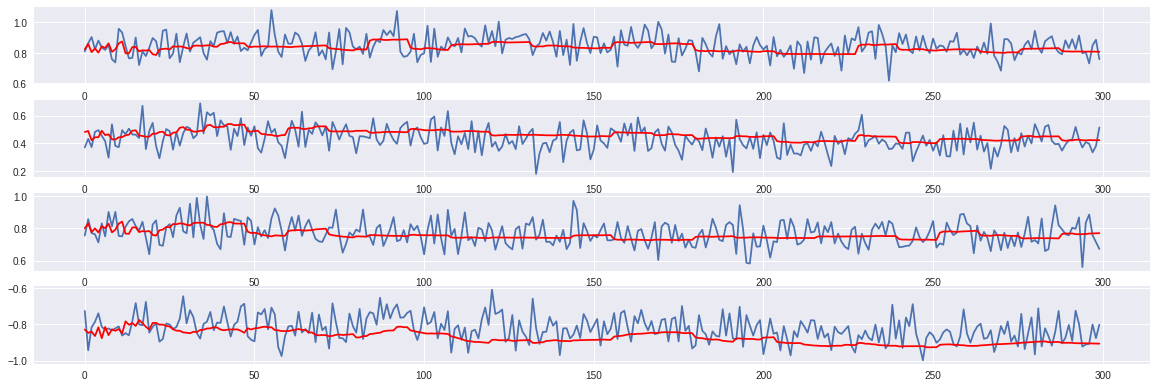

In [26]:
from keras import backend as K
from keras.models import load_model


# sample_1 = data_block[np.newaxis, 1000]
sample_1 = x_test[np.newaxis, 688]
output_1 = best_model.predict(sample_1)

# sample_2 = data_block[np.newaxis, 10]
sample_2 = x_test[np.newaxis, 33]
output_2 = best_model.predict(sample_2)

# sample_3 = data_block[np.newaxis, 66]
sample_3 = x_test[np.newaxis, 123]
output_3 = best_model.predict(sample_3)

# sample_4 = data_block[np.newaxis, 6000]
sample_4 = x_test[np.newaxis, 98]
output_4 = best_model.predict(sample_4)


plt.figure(figsize=(20, 10))
plt.subplot(611)
plt.plot(np.squeeze(sample_1))
plt.plot(np.squeeze(output_1), c='r')
plt.subplot(612)
plt.plot(np.squeeze(sample_2))
plt.plot(np.squeeze(output_2), c='r')
plt.subplot(613)
plt.plot(np.squeeze(sample_3))
plt.plot(np.squeeze(output_3), c='r')
plt.subplot(614)
plt.plot(np.squeeze(sample_4))
plt.plot(np.squeeze(output_4), c='r')


In [22]:
# DO NOT SUBTRACT MEAN + WHITEN. big outliers ruin sensitivity to local behavior.